<a href="https://colab.research.google.com/github/uzairname/OtsegoStoryProject/blob/main/experiments/Final_Analysis_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import numpy as np

# -------------------------------
# 1. Data Loading & Preprocessing
# -------------------------------
nltk.download('vader_lexicon')

# Load CSV (ensure the file is in your working directory)
df = pd.read_csv('data/otsego_good_maybe.csv', parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notnull()]  # Remove rows with invalid timestamps
df['content'] = df['content'].fillna("").astype(str)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


FileNotFoundError: [Errno 2] No such file or directory: 'data/otsego_good_maybe.csv'

In [ ]:
# -------------------------------
# 2. Sentiment Analysis: VADER
# -------------------------------
vader = SentimentIntensityAnalyzer()
df['vader_compound'] = df['content'].apply(lambda x: vader.polarity_scores(x)['compound'])

# -------------------------------
# 3. Sentiment Analysis: BERT
# -------------------------------
# Initialize a BERT sentiment-analysis pipeline.
bert_pipeline = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# bert_pipeline("a")


# def get_bert_compound(text):
#     # Get the sentiment result (returns a list of dicts)
#     result = bert_pipeline(text)
#     # Extract the star rating from the label (e.g., "4 stars")
#     label = result[0]['label']
#     rating = int(label.split()[0])
#     # Map rating (1-5) to a compound score between -1 and 1:
#     # 1 -> -1.0, 2 -> -0.5, 3 -> 0.0, 4 -> 0.5, 5 -> 1.0
#     compound = (rating - 3) / 2.0
#     return compound

# # Apply BERT sentiment analysis (this may take a bit, depending on the dataset size)
# df['bert_compound'] = df['content'].apply(get_bert_compound)

NameError: name 'init_empty_weights' is not defined

In [ ]:
# -------------------------------
# 2. Sentiment Analysis: VADER
# -------------------------------
vader = SentimentIntensityAnalyzer()
df['vader_compound'] = df['content'].apply(lambda x: vader.polarity_scores(x)['compound'])

# -------------------------------
# 3. Sentiment Analysis: BERT
# -------------------------------
# Initialize a BERT sentiment-analysis pipeline.
bert_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def get_bert_compound(text):
    # Get the sentiment result (returns a list of dicts)
    result = bert_pipeline(text)
    # Extract the star rating from the label (e.g., "4 stars")
    label = result[0]['label']
    rating = int(label.split()[0])
    # Map rating (1-5) to a compound score between -1 and 1:
    # 1 -> -1.0, 2 -> -0.5, 3 -> 0.0, 4 -> 0.5, 5 -> 1.0
    compound = (rating - 3) / 2.0
    return compound

# Apply BERT sentiment analysis (this may take a bit, depending on the dataset size)
df['bert_compound'] = df['content'].apply(get_bert_compound)

# -------------------------------
# 4. Daily Aggregation & Forecasting
# -------------------------------
# Create a date column
df['date'] = df['timestamp'].dt.date

# Aggregate daily average sentiment for VADER and BERT
daily_vader = df.groupby('date')['vader_compound'].mean().reset_index().rename(columns={'vader_compound': 'avg_compound'})
daily_bert = df.groupby('date')['bert_compound'].mean().reset_index().rename(columns={'bert_compound': 'avg_compound'})

# Forecast function using linear regression
def forecast_sentiment(daily_df):
    # Convert dates to ordinal numbers for regression
    daily_df['date_ordinal'] = pd.to_datetime(daily_df['date']).apply(lambda date: date.toordinal())
    X = daily_df['date_ordinal'].values.reshape(-1, 1)
    y = daily_df['avg_compound'].values
    model = LinearRegression()
    model.fit(X, y)

    # Forecast from the day after the last date until the end of 2026
    last_date = pd.to_datetime(daily_df['date'].max())
    future_dates = pd.date_range(start=last_date + timedelta(days=1), end=pd.Timestamp("2026-12-31"))
    future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
    predicted = model.predict(future_ordinals)
    future_df = pd.DataFrame({'date': future_dates, 'predicted_compound': predicted})
    return future_df

future_vader = forecast_sentiment(daily_vader)
future_bert = forecast_sentiment(daily_bert)

# -------------------------------
# 5. Visualization
# -------------------------------

# Figure 1: Trend Plots (side-by-side) for VADER and BERT with Forecasts
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# VADER Plot
axs[0].plot(daily_vader['date'], daily_vader['avg_compound'], marker='o', label='Historical')
axs[0].plot(future_vader['date'], future_vader['predicted_compound'], marker='x', linestyle='--', label='Forecast')
axs[0].set_xlabel('Date', fontsize=12)
axs[0].set_ylabel('Avg Compound Sentiment', fontsize=12)
axs[0].set_title('VADER Sentiment Trend & Forecast', fontsize=14)
axs[0].set_ylim(-1, 1)
axs[0].axhline(y=0.05, color='gray', linestyle='--', linewidth=1)
axs[0].axhline(y=-0.05, color='gray', linestyle='--', linewidth=1)
axs[0].grid(True)
axs[0].legend(fontsize=10)
axs[0].text(daily_vader['date'].iloc[-1], 0.07, 'Positive', color='green', fontsize=10)
axs[0].text(daily_vader['date'].iloc[-1], 0.00, 'Neutral', color='blue', fontsize=10)
axs[0].text(daily_vader['date'].iloc[-1], -0.09, 'Negative', color='red', fontsize=10)

# BERT Plot
axs[1].plot(daily_bert['date'], daily_bert['avg_compound'], marker='o', label='Historical')
axs[1].plot(future_bert['date'], future_bert['predicted_compound'], marker='x', linestyle='--', label='Forecast')
axs[1].set_xlabel('Date', fontsize=12)
axs[1].set_title('BERT Sentiment Trend & Forecast', fontsize=14)
axs[1].set_ylim(-1, 1)
axs[1].axhline(y=0.05, color='gray', linestyle='--', linewidth=1)
axs[1].axhline(y=-0.05, color='gray', linestyle='--', linewidth=1)
axs[1].grid(True)
axs[1].legend(fontsize=10)
axs[1].text(daily_bert['date'].iloc[-1], 0.07, 'Positive', color='green', fontsize=10)
axs[1].text(daily_bert['date'].iloc[-1], 0.00, 'Neutral', color='blue', fontsize=10)
axs[1].text(daily_bert['date'].iloc[-1], -0.09, 'Negative', color='red', fontsize=10)

plt.tight_layout()
plt.show()

# Figure 2: Scatter Plot Comparing VADER vs. BERT for Each Post
plt.figure(figsize=(8, 6))
plt.scatter(df['vader_compound'], df['bert_compound'], alpha=0.6)
plt.xlabel('VADER Compound Score', fontsize=12)
plt.ylabel('BERT Compound Score', fontsize=12)
plt.title('VADER vs. BERT Sentiment Scores', fontsize=14)
plt.grid(True)
lims = [-1, 1]
plt.plot(lims, lims, 'r--', linewidth=1)  # Diagonal reference line
plt.xlim(lims)
plt.ylim(lims)
plt.tight_layout()
plt.show()

# Figure 3: Histograms of Sentiment Distributions for VADER and BERT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax1.hist(df['vader_compound'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title('VADER Sentiment Distribution', fontsize=14)
ax1.set_xlabel('VADER Compound Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_xlim(-1, 1)
ax1.grid(True)

ax2.hist(df['bert_compound'], bins=20, color='salmon', edgecolor='black')
ax2.set_title('BERT Sentiment Distribution', fontsize=14)
ax2.set_xlabel('BERT Compound Score', fontsize=12)
ax2.set_xlim(-1, 1)
ax2.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# 6. Summary Statistics & Analysis Output
# -------------------------------


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

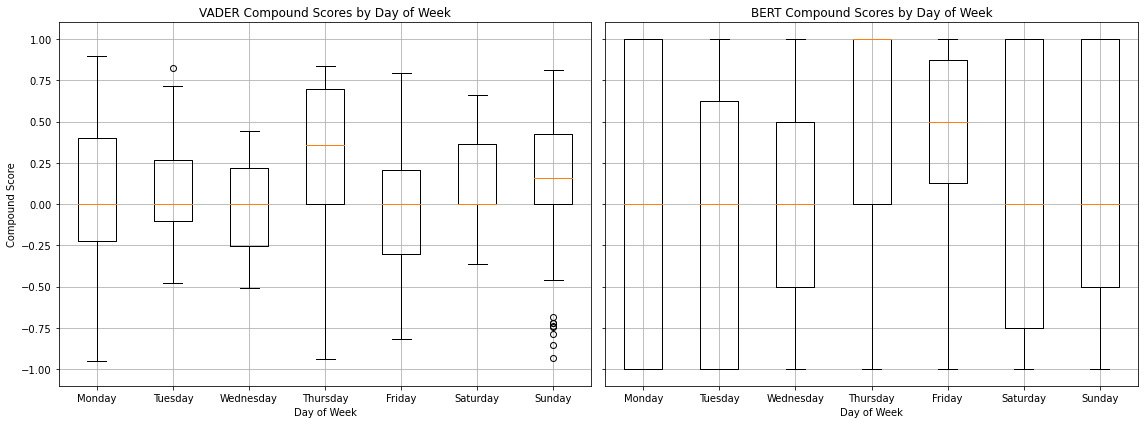

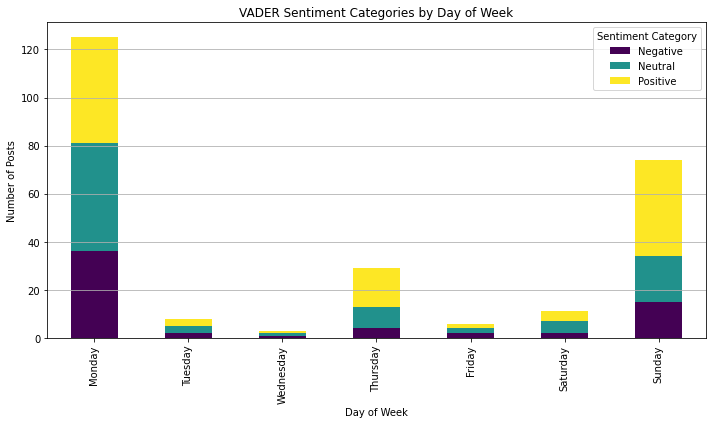

Summary Statistics:
Total posts analyzed: 256
Average VADER compound score: 0.086
Average BERT compound score: 0.092
Standard Deviation VADER compound score: 0.449
Standard Deviation BERT compound score: 0.800

VADER Sentiment Category Counts:
Positive    110
Neutral      84
Negative     62
Name: vader_compound, dtype: int64

BERT Sentiment Category Counts:
Positive    117
Negative     91
Neutral      48
Name: bert_compound, dtype: int64

Correlation between VADER and BERT compound scores: 0.437


In [ ]:
# Additional Visualizations

import matplotlib.pyplot as plt

# --- Visualization 4: Box Plots of VADER and BERT Compound Scores by Day of Week ---

# Create a 'day_of_week' column in the DataFrame with proper ordering
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['day_of_week'] = pd.Categorical(df['timestamp'].dt.day_name(), categories=days_order, ordered=True)

# Prepare the data lists for each day for both VADER and BERT scores
vader_box_data = [df.loc[df['day_of_week'] == day, 'vader_compound'].dropna() for day in days_order]
bert_box_data = [df.loc[df['day_of_week'] == day, 'bert_compound'].dropna() for day in days_order]

# Create side-by-side box plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axs[0].boxplot(vader_box_data, labels=days_order)
axs[0].set_title("VADER Compound Scores by Day of Week")
axs[0].set_xlabel("Day of Week")
axs[0].set_ylabel("Compound Score")
axs[0].grid(True)

axs[1].boxplot(bert_box_data, labels=days_order)
axs[1].set_title("BERT Compound Scores by Day of Week")
axs[1].set_xlabel("Day of Week")
axs[1].grid(True)

plt.tight_layout()
plt.show()


# --- Visualization 5: Stacked Bar Chart of VADER Sentiment Categories by Day of Week ---

# Define a helper function to assign sentiment categories for VADER
def categorize(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to create a new category column for VADER scores
df['vader_category'] = df['vader_compound'].apply(categorize)

# Create a pivot table: counts of sentiment categories by day of week
pivot = df.groupby('day_of_week')['vader_category'].value_counts().unstack().fillna(0).loc[days_order]

# Plot a stacked bar chart for the VADER sentiment categories by day
pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("VADER Sentiment Categories by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Posts")
plt.legend(title="Sentiment Category")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print("Summary Statistics:")

total_posts = len(df)
print(f"Total posts analyzed: {total_posts}")

avg_vader = df['vader_compound'].mean()
avg_bert = df['bert_compound'].mean()
std_vader = df['vader_compound'].std()
std_bert = df['bert_compound'].std()

print(f"Average VADER compound score: {avg_vader:.3f}")
print(f"Average BERT compound score: {avg_bert:.3f}")
print(f"Standard Deviation VADER compound score: {std_vader:.3f}")
print(f"Standard Deviation BERT compound score: {std_bert:.3f}")

# Define a helper function to assign a sentiment category
def categorize(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

vader_categories = df['vader_compound'].apply(categorize)
bert_categories = df['bert_compound'].apply(categorize)

vader_counts = vader_categories.value_counts()
bert_counts = bert_categories.value_counts()

print("\nVADER Sentiment Category Counts:")
print(vader_counts)
print("\nBERT Sentiment Category Counts:")
print(bert_counts)

corr = df['vader_compound'].corr(df['bert_compound'])
print(f"\nCorrelation between VADER and BERT compound scores: {corr:.3f}")

# Sentiment Analysis Summary

**Total Posts Analyzed:** 256

## Overall Sentiment
- **VADER Average Compound:** 0.086  
- **BERT Average Compound:** 0.092  
*Both methods show slightly positive averages, but these can mask underlying complexity.*

- **VADER Std. Dev.:** 0.449  
- **BERT Std. Dev.:** 0.800  
*BERT exhibits a wider range, indicating more extreme sentiment values.*

## Sentiment Categories
- **VADER Counts:**
  - Positive: 110
  - Neutral: 84
  - Negative: 62

- **BERT Counts:**
  - Positive: 117
  - Negative: 91
  - Neutral: 48

*BERT flags more negative posts, suggesting higher sensitivity to distress.*

## Correlation Between Methods
- **Correlation:** 0.437  
*Moderate correlation indicates the two methods capture sentiment differently.*

## Insights & Recommendations
- **Context Matters:**  
  The slightly positive averages hide variability. BERT’s higher negative count may better reflect community distress.
  
- **Multiple Methods:**  
  Using both VADER and BERT provides a fuller picture. Consider fine-tuning BERT on domain-specific data for improved accuracy.

- **Additional Visualizations:**  
  - **Heatmaps/Calendar Plots:** Identify periods with heightened negative sentiment.  
  - **Topic Modeling:** Use LDA to link themes (e.g., water quality, cancer) with sentiment trends.  
  - **Event Annotations:** Overlay key community events on trend graphs to contextualize shifts in sentiment.

## Conclusion
While overall sentiment appears slightly positive, the variability and methodological differences (especially BERT’s detection of more negative sentiment) suggest that the community's emotional response is more nuanced and polarized. This underscores the need for a combined quantitative and qualitative approach to fully capture the community's experiences, particularly given the serious issues of water quality and health.

